In [1]:
import random
from engine import Tensor
from nn import MLP
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
np.random.seed(1337)
random.seed(1337)

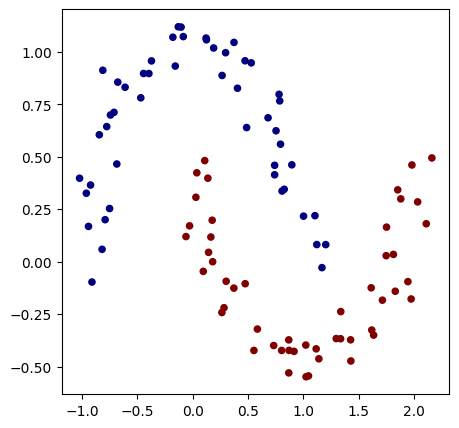

In [5]:
from sklearn.datasets import make_moons, make_blobs

X, y = make_moons(n_samples=100, noise=0.1)

y = y * 2 - 1  # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap="jet")

In [6]:
# initialize a model
model = MLP( [2,16],1)  # 2-layer neural network


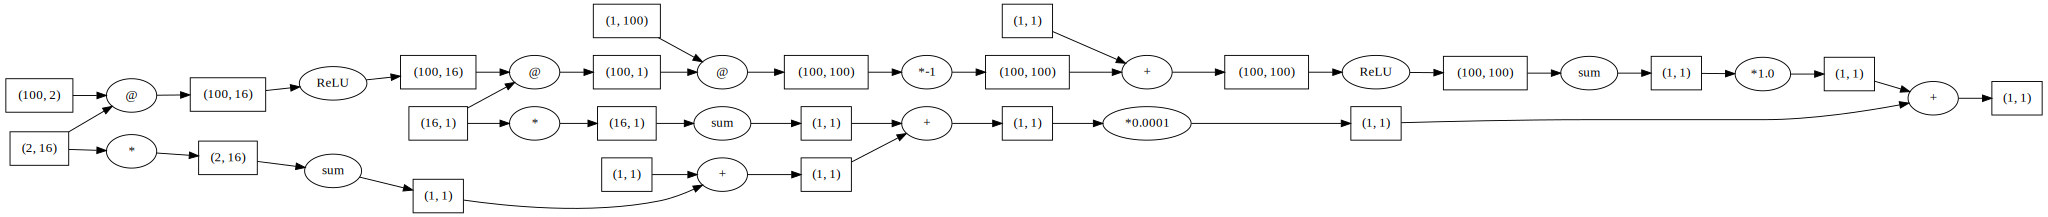

In [7]:
def loss(batch_size=None):
    # Inline DataLoader :)
    if batch_size is None:
        Xb, yb = Tensor(X), Tensor(y)  # Full dataset
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]  # Select a random batch
        Xb, yb = Tensor(X[ri]), Tensor(y[ri])

    # Forward pass through the model
    inputs = Xb  # Convert Xb to a Tensor
    scores = model(inputs)  # Scores will now be a Tensor



    # SVM "max-margin" loss
    one = Tensor(1)  # Maintain this as a tensor for autograd
    margins = one -  scores @ yb  # The margins
    margins = margins.relu()

    # Instead of constructing a new tensor, use the existing margin tensor to accumulate loss
    data_loss = margins.sum() / len(yb.data)
  

    # L2 regularization (stay in the autograd graph)
    alpha = 1e-4
    reg_loss = alpha * sum(
        (p * p).sum() for p in model.parameters()
    )  # Regularization term
    total_loss = data_loss + reg_loss  # Total loss

    # Accuracy computation (vectorized)
    accuracy = ((np.array(yb.data) > 0) == (np.array(scores.data) > 0)).mean()

    return total_loss, accuracy,scores

total_loss, acc,scores = loss()
total_loss.visualize()


Step 0, Loss: [[11435.50603481]], Accuracy: 50.0%
Step 10, Loss: [[3.01082901e+47]], Accuracy: 50.0%
Step 20, Loss: [[1.53492449e+91]], Accuracy: 50.0%
Step 30, Loss: [[7.16011915e+134]], Accuracy: 50.0%
Step 40, Loss: [[4.26141866e+178]], Accuracy: 50.0%
Step 50, Loss: [[2.69788773e+222]], Accuracy: 50.0%
Step 60, Loss: [[1.92158299e+266]], Accuracy: 50.0%
Step 70, Loss: [[inf]], Accuracy: 50.0%
Step 80, Loss: [[inf]], Accuracy: 50.0%
Step 90, Loss: [[nan]], Accuracy: 50.0%


/home/raid/miniconda3/envs/main/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/tmp/ipykernel_183667/913573301.py:79: RuntimeWarning: overflow encountered in matmul
  other.grad += self.data.T @ out.grad
/tmp/ipykernel_183667/913573301.py:78: RuntimeWarning: overflow encountered in matmul
  self.grad += out.grad @ other.data.T
/tmp/ipykernel_183667/913573301.py:75: RuntimeWarning: overflow encountered in matmul
  out = Tensor(self.data @ other.data, (self, other), "@")
/tmp/ipykernel_183667/913573301.py:49: RuntimeWarning: overflow encountered in multiply
  out = Tensor(self.data * other.data, (self,other), f"*")
/tmp/ipykernel_183667/913573301.py:79: RuntimeWarning: invalid value encountered in matmul
  other.grad += self.data.T @ out.grad
/tmp/ipykernel_183667/913573301.py:75: RuntimeWarning: invalid value encountered in matmul
  out = Tensor(self.data @ other.data,

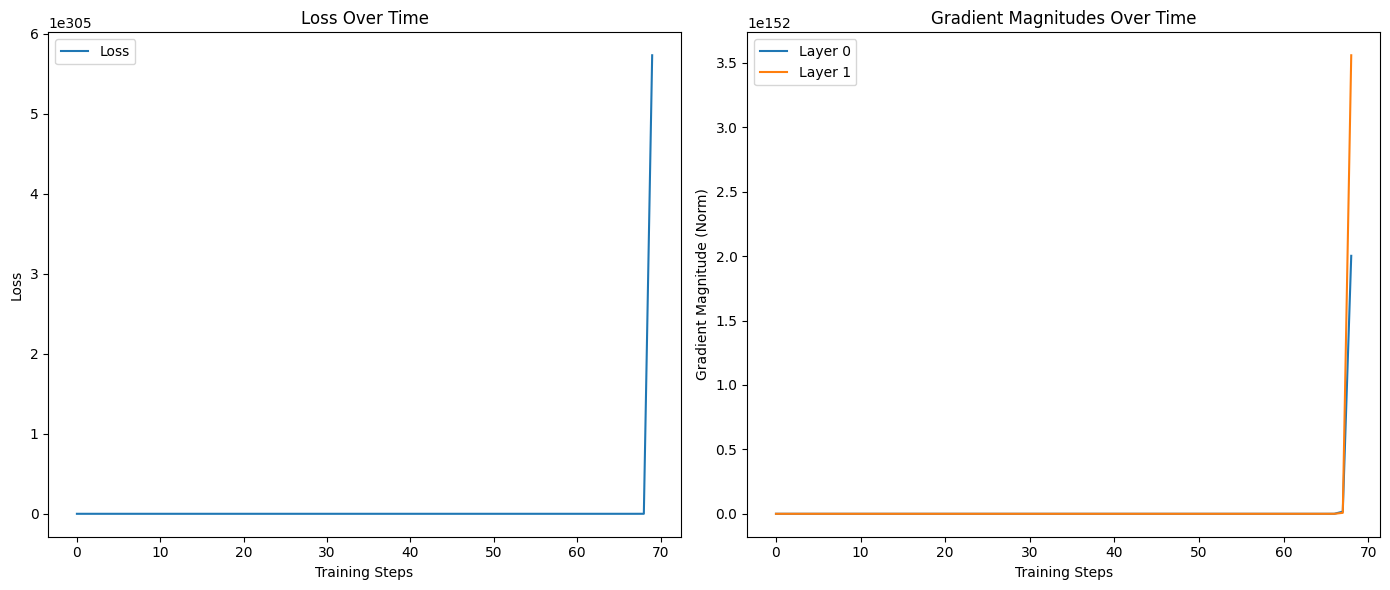

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize a dictionary to store gradient norms
gradient_magnitudes = {name: [] for name, _ in enumerate(model.parameters())}
losses = []

t = 100
for k in range(t):

    # Forward pass
    total_loss, acc,scores = loss()


    model.zero_grad()
    # Backward pass
    total_loss.backward()

    # Track the loss value
    losses.append(total_loss.data[0][0])

    # Learning rate schedule
    learning_rate = 0.1 - 0.001 * k / t

    # Update parameters using SGD and track gradient norms
    for i, p in enumerate(model.parameters()):
        # Calculate gradient norm (magnitude)
        grad_norm = np.linalg.norm(p.grad)
        gradient_magnitudes[i].append(grad_norm)  # Track gradient norm

        # SGD update step
        p.data -= learning_rate * p.grad

    # Print status
    if k % 10 == 0:  # Printing every 10 steps for brevity
        print(f"Step {k}, Loss: {total_loss.data}, Accuracy: {acc * 100}%")

# Plotting both loss and gradient magnitudes

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot loss over time
ax[0].plot(losses, label="Loss")
ax[0].set_title("Loss Over Time")
ax[0].set_xlabel("Training Steps")
ax[0].set_ylabel("Loss")
ax[0].legend()

# Plot gradient magnitudes over time for each layer
for i, norms in gradient_magnitudes.items():
    ax[1].plot(norms, label=f"Layer {i}")
ax[1].set_title("Gradient Magnitudes Over Time")
ax[1].set_xlabel("Training Steps")
ax[1].set_ylabel("Gradient Magnitude (Norm)")
ax[1].legend()

plt.tight_layout()
plt.show()

/tmp/ipykernel_183667/913573301.py:75: RuntimeWarning: overflow encountered in matmul
  out = Tensor(self.data @ other.data, (self, other), "@")
/tmp/ipykernel_183667/913573301.py:75: RuntimeWarning: invalid value encountered in matmul
  out = Tensor(self.data @ other.data, (self, other), "@")


(-1.548639298268643, 1.951360701731357)

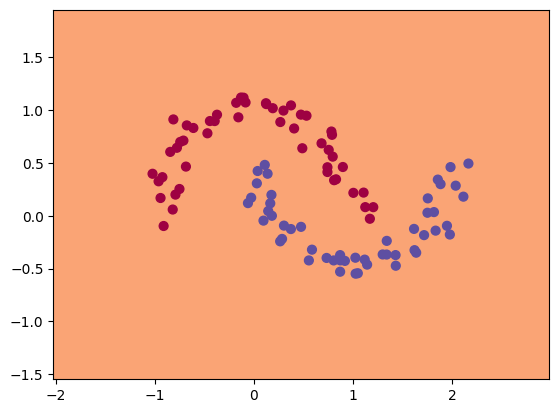

In [9]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = Tensor(Xmesh)
scores = model(inputs)
Z = np.array([s > 0 for s in scores.data])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())